In [5]:
from os import chdir

# change directory to the root of the project
chdir("../")

# Libraries import


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import signal

import hw_predictor.utils as su


from scipy.stats import norm
from scipy.optimize import curve_fit

# Parameters


In [8]:
STATION_ID = 390006
#330020
INPUT_PATH = f"data/input/stations/{STATION_ID}"

# Utilities


In [37]:
#chdir('data')
### ls

input     output    reporting


# Code


In [9]:
data = pd.read_parquet(f"{INPUT_PATH}/daily_temp_history")

#mask = ~(data.index.month == 2) | ((data.index.day != 29) & (data.index.day != 30) & (data.index.day != 31))

#data = data[mask]

In [10]:
#data = pd.read_parquet(f"{INPUT_PATH}/daily_temp_history")


# normalize index and get only 'max_temp' non-null entries
max_temp = data.set_index(data.index.normalize()).dropna(subset=["max_temp"])[["max_temp"]]
mean_temp = data.set_index(data.index.normalize()).dropna(subset=["mean_temp"])[["mean_temp"]]
min_temp = data.set_index(data.index.normalize()).dropna(subset=["min_temp"])[["min_temp"]]



print(max_temp)
#print(mean_temp)
print(min_temp)

            max_temp
date                
1966-01-01      22.3
1966-01-02      21.4
1966-01-03      25.5
1966-01-04      22.2
1966-01-05      19.6
...              ...
2023-10-31      16.2
2023-11-01      17.7
2023-11-02      19.0
2023-11-03      18.3
2023-11-04      17.7

[20551 rows x 1 columns]
            min_temp
date                
1966-01-01      12.3
1966-01-02       8.0
1966-01-03       8.0
1966-01-04       8.0
1966-01-05       8.0
...              ...
2023-11-01       5.2
2023-11-02       2.7
2023-11-03       2.7
2023-11-04       1.6
2023-11-05      11.2

[20418 rows x 1 columns]


## Read the necessary for Ta

In [514]:
air_temp_data = pd.read_parquet(f"{INPUT_PATH}/T_apparent_history/air_temp_history.parquet")
dew_point_data = pd.read_parquet(f"{INPUT_PATH}/T_apparent_history/dew_point_history.parquet")

In [515]:
print(air_temp_data)
print(dew_point_data)

                     Ts_Valor
timestamp                    
01-01-1950 12:00:00      18.6
01-01-1950 18:00:00      26.4
01-01-1950 23:00:00      23.5
02-01-1950 12:00:00      14.3
02-01-1950 18:00:00      25.6
...                       ...
18-10-2023 03:00:00      14.6
18-10-2023 04:00:00      13.5
18-10-2023 05:00:00      13.2
18-10-2023 06:00:00      12.7
18-10-2023 07:00:00      10.7

[195136 rows x 1 columns]
                     dew_point_temp
timestamp                          
01-03-1967 00:00:00             NaN
01-03-1967 12:00:00            11.6
01-03-1967 18:00:00            16.0
02-03-1967 00:00:00            17.9
02-03-1967 12:00:00            12.7
...                             ...
18-10-2023 03:00:00             4.1
18-10-2023 04:00:00             4.5
18-10-2023 05:00:00             4.6
18-10-2023 06:00:00             5.8
18-10-2023 07:00:00             7.6

[176093 rows x 1 columns]


In [11]:
# common indices
common_indices = air_temp_data.index.intersection(dew_point_data.index)
#print(common_indices)

common_air_temp = air_temp_data.loc[common_indices]
common_dew_point = dew_point_data.loc[common_indices]

# Create a new DataFrame with the common data
common_data = pd.concat([common_air_temp, common_dew_point], axis=1)
common_data['app_temp'] = None

common_data['app_temp'] = -2.653 + 0.994*common_data['Ts_Valor'] + 0.0153*common_data['dew_point_temp']**2 # 2 * common_data['df1'] + common_data['df2']**2
#print(common_data)


common_data.index = pd.to_datetime(common_data.index, format='%d-%m-%Y %H:%M:%S')

#TaMax
daily_max_values = common_data.groupby(common_data.index.date)['app_temp'].max()
daily_max_values_df = daily_max_values.to_frame()#name='daily_Ta_max')
daily_max_values_series = daily_max_values_df.squeeze()
daily_max_values_series = daily_max_values_series.rename_axis('date')
Ta_max_data = daily_max_values_series.to_frame(name='Ta_max')

#TaMin
daily_min_values = common_data.groupby(common_data.index.date)['app_temp'].min()
daily_min_values_df = daily_min_values.to_frame()#name='daily_Ta_max')
daily_min_values_series = daily_min_values_df.squeeze()
daily_min_values_series = daily_min_values_series.rename_axis('date')
Ta_min_data = daily_min_values_series.to_frame(name='Ta_min')


print(Ta_max_data)
print(Ta_min_data)

NameError: name 'air_temp_data' is not defined

In [517]:
print(data)
print('Ta_max_data', Ta_max_data)

            min_temp  max_temp  mean_temp  cond_mean_temp  hourly_data_count   
date                                                                           
1950-01-01       NaN       NaN       22.8             NaN                3.0  \
1950-01-02       NaN       NaN       20.9             NaN                3.0   
1950-01-03       NaN       NaN       20.3             NaN                3.0   
1950-01-04       NaN       NaN       22.0             NaN                3.0   
1950-01-05       NaN       NaN       22.4             NaN                3.0   
...              ...       ...        ...             ...                ...   
2023-09-16       7.6      21.6       14.6            14.6               24.0   
2023-09-17       9.9      11.7       11.0            11.0               24.0   
2023-09-18       6.8      15.1       10.2            10.2               24.0   
2023-09-19       8.5      20.6       12.7            12.7               24.0   
2023-09-20       9.6       NaN       12.

In [518]:
data_plus_Ta = data.copy()
data_plus_Ta['Ta_max'] = None
data_plus_Ta['Ta_min'] = None

data_plus_Ta['Ta_max'] = Ta_max_data
data_plus_Ta['Ta_min'] = Ta_min_data
print(data_plus_Ta['Ta_max'])
print(data_plus_Ta['Ta_min'])
#print(data_plus_Ta['Ta_max'])
#print(data_plus_Ta['max_temp'])
data = data_plus_Ta.copy()

date
1950-01-01          NaN
1950-01-02          NaN
1950-01-03          NaN
1950-01-04          NaN
1950-01-05          NaN
                ...    
2023-09-16    19.324233
2023-09-17    12.166153
2023-09-18    12.923468
2023-09-19    17.789225
2023-09-20    15.854513
Name: Ta_max, Length: 26926, dtype: float64
date
1950-01-01         NaN
1950-01-02         NaN
1950-01-03         NaN
1950-01-04         NaN
1950-01-05         NaN
                ...   
2023-09-16    5.828633
2023-09-17    7.384352
2023-09-18    5.111872
2023-09-19    6.820288
2023-09-20    7.796537
Name: Ta_min, Length: 26926, dtype: float64


In [519]:
Ta_max = data.set_index(data.index.normalize()).dropna(subset=["Ta_max"])[["Ta_max"]]
Ta_min = data.set_index(data.index.normalize()).dropna(subset=["Ta_min"])[["Ta_min"]]

# Functions

## Settings and basic functions for (Tind, Tcri, Nd)

In [12]:
from calendar import monthrange
from datetime import datetime, timedelta

# get the number of days in each month for given year
#   - with this data we can compute the ext_threhold for each month/day in the year

year = 2020
start_year = 2000
end_year = 2023

start_date = datetime(start_year, 1, 1)
end_date = datetime(end_year, 12, 31) #12, 31)

#year = datetime.now().year - 1


month_days = {"year": year, "month_days": {m: monthrange(year, m)[1] for m in range(1, 13)}}

#month_days = {"month_days": {Y: {m: monthrange(Y, m)[1] for m in range(1, 13)} for Y in range(2020, 2023)}}

month_days

{'year': 2020,
 'month_days': {1: 31,
  2: 29,
  3: 31,
  4: 30,
  5: 31,
  6: 30,
  7: 31,
  8: 31,
  9: 30,
  10: 31,
  11: 30,
  12: 31}}

In [538]:
#year_month_days = {"year": {Y, "month_days": {m: monthrange(year, m)[1] for m in range(1, 13)} for Y in range(start_date.year, end_date.year+1)}}
#month_days_0 = {"month_days": {Y: {m: monthrange(Y, m)[1] for m in range(1, 13)} for Y in range(2020, 2023)}}

#month_days_0


## Functions for $T_{ind}$

In [13]:
def Tind(Tind_type: str, data_temp: pd.DataFrame):
    # compute the thresholds ####90-percentile for each month/day in the year
    data_temp_Period = pd.DataFrame(
        [],
        columns=[Tind_type], #"max_temp", "P90", "mean", "mean+5", "P90_russo_set"],
        index=pd.Index(pd.date_range(start_date, end_date, freq="D"), name="date"),
    )
    #print(max_temp_2023)
    # add entries from 2023
    mask = (data_temp.index >= start_date) & (data_temp.index <= end_date)
    data_temp_Period[Tind_type] = data_temp[mask]
    #data_temp_Period[Tind_type] = data_temp[(data_temp.index.year == Period)] # + (max_temp.index.year == 2022)]
    return data_temp_Period

In [540]:
#datetime(year, 1, 1)

datetime.datetime(2020, 1, 1, 0, 0)

In [604]:
#Tind_type_1 = 'max_temp'
#sns.scatterplot(Tind(Tind_type_1, max_temp), y=Tind_type_1, x="date", label=Tind_type_1, color = 'red', s=5)

## Functions for $T_{crit}$

In [14]:
######### METEOCHILE NEW METHODOLOGY
def model(x, params):
    a, a1, b1 = params
    omega = 2 * np.pi / 365.25  # 365.25
    theta = np.arctan(a1 / b1)
    alpha = np.sqrt(a1**2 + b1**2)

    y_pred = a + alpha * np.sin(omega * x + theta)
    return y_pred


def model_fit(x, a, a1, b1):
    omega = 2 * np.pi / 365.25
    y_pred = a + a1 * np.cos(omega * x) + b1 * np.sin(omega * x)
    return y_pred


def RSS(y, y_pred) -> float:
    return np.sqrt((y - y_pred) ** 2).sum()



### SET FOR RUSSO 2014:
def set_Russo2014(year, month, day, start_date, end_date, data_temp):
    start_year = start_date.year
    start_month = start_date.month
    start_day = start_date.day

    end_year = end_date.year
    end_month = end_date.month
    end_day = end_date.day

    RS = []
    # Initialize a variable for the current year
    current_year = start_date.year
    while current_year <= end_date.year:
        dateref = datetime(year, month, day)
        #print('ref date?', datetime(year, month, day))
        # Iterate through all combinations of dates
        for i in range(-15,16):
            try:
                dateS = datetime(current_year, month, day) + timedelta(days=i)
            except ValueError:
                dateS = datetime(current_year, month, day-1) #+ timedelta(days=i)
            #print('dateS successful')
            try:
                RS.append(max_temp['max_temp'][dateS])
            except KeyError:
                aaaaa = 1 #there is no info for this date
        current_year += 1
    return RS

def Tcrit(Tcrit_type: str, data_temp: pd.DataFrame, Tadd = None, perc = None):
    data_temp_2023 = pd.DataFrame(
        [],
        columns=[Tcrit_type], #"max_temp", "P90", "mean", "mean+5", "P90_russo_set"],
        index=pd.Index(pd.date_range(start_date, end_date, freq="D"), name="date"),
    )
    if Tcrit_type == '90_percentile_adj':
        # new method
        data_temp_2023 = Tcrit('P90', max_temp)
        temp_t = data_temp_2023["P90"].copy(deep=True)
        temp_t = temp_t.to_frame()
        if isinstance(temp_t.index, pd.DatetimeIndex):
            first_ord = temp_t.index.map(datetime.toordinal)[0]
            temp_t.index = temp_t.index.map(datetime.toordinal)


        params, cov = curve_fit(
            model_fit, xdata=temp_t.index - first_ord, ydata=temp_t["P90"], method="lm"
        )
        param_list = ["a", "a1", "b1"]
        print("a + a1*cos(omega*x) + b1*sin(omega*x) \n")

        std_dev = np.sqrt(np.diag(cov))
        for name, p, sd in zip(param_list, params, std_dev):
            print(
                "{0} :  {1:0.3}  CI ~ N [{2:0.2e},{3:0.2e}]".format(name, p, p - 1.96 * sd, p + 1.96 * sd)
            )

        data_temp_2023.loc[:, "90_percentile_adj"] = model(temp_t.index - first_ord, params)
        if isinstance(temp_t.index, pd.DatetimeIndex):
            temp_t.index = temp_t.index.map(datetime.toordinal)

    elif isinstance(Tcrit_type, float):
        return Tcrit_type
    else:
        for year in range(start_date.year, end_date.year + 1):
            for month in month_days["month_days"]:
                for day in range(1, month_days["month_days"][month] + 1):
                    try:
                        current_date = datetime(year, month, day)
                    except ValueError:
                        current_date = datetime(year, month, day-1)
                    if  current_date >= start_date and current_date <= end_date:
                        f_data_temp = data_temp[
                            (1981 <= data_temp.index.year)
                            & (data_temp.index.year <= 2010)
                            & (data_temp.index.day == day)
                            & (data_temp.index.month == month)
                        ]
                        if Tcrit_type == 'P90':
                            try:
                                data_temp_2023.loc[datetime(year, month, day), "P90"] = f_data_temp.quantile(
                                    0.9, interpolation="midpoint"
                                ).values[0]
                            except ValueError:
                                data_temp_2023.loc[datetime(year, month, day-1), "P90"] = f_data_temp.quantile(
                                    0.9, interpolation="midpoint"
                                ).values[0]
                        if Tcrit_type == 'P85':
                            try:
                                data_temp_2023.loc[datetime(year, month, day), "P85"] = f_data_temp.quantile(
                                    0.85, interpolation="midpoint"
                                ).values[0]
                            except ValueError:
                                data_temp_2023.loc[datetime(year, month, day-1), "P85"] = f_data_temp.quantile(
                                    0.85, interpolation="midpoint"
                                ).values[0]
                        elif Tcrit_type == 'mean':
                            try:
                                data_temp_2023.loc[datetime(year, month, day), "mean"] = f_data_temp.mean().values[0]
                            except ValueError:
                                data_temp_2023.loc[datetime(year, month, day-1), "mean"] = f_data_temp.mean().values[0]
                        elif Tcrit_type == 'mean+' + str(Tadd):
                            try:
                                data_temp_2023.loc[datetime(year, month, day), "mean+" + str(Tadd)] = f_data_temp.mean().values[0] + Tadd
                            except ValueError:
                                data_temp_2023.loc[datetime(year, month, day-1), "mean+" + str(Tadd)] = f_data_temp.mean().values[0] + Tadd
                        elif Tcrit_type == 'P90_russo_set':
                            try:
                                SR = set_Russo2014(year, month, day, datetime(1981, 1, 1), datetime(2010, 12, 31), max_temp)
                                data_temp_2023.loc[datetime(year, month, day), "P90_russo_set"] = np.percentile(SR, 90)
                            except ValueError:
                                SR = set_Russo2014(year, month, day-1, datetime(1981, 1, 1), datetime(2010, 12, 31), max_temp)
                                data_temp_2023.loc[datetime(year, month, day-1), "P90_russo_set"] = np.percentile(SR, 90)


    return data_temp_2023

In [564]:
range(start_date.year, end_date.year)

range(2000, 2023)

## HW function

In [15]:
def HWD(Tind_type: str,
        Tcrit_type: str,
        Nd: int,
        data_temp_2023: pd.DataFrame):

    # create binary column with 1 if the max_temp is above the (personal) threshold
    data_temp_2023.loc[:, "above_threshold"] = (
        data_temp_2023[Tcrit_type] < data_temp_2023[Tind_type]
    ).astype(int)

    temps_above_threshold = data_temp_2023[data_temp_2023["above_threshold"] == 1].copy(deep=True)

    # create dataframe with heatwaves information (start, end, duration, mean_temp, max_temp, date)
    heatwaves = pd.DataFrame(
        columns=["start", "end", "duration", "mean_temp", "min_temp", "max_temp", "date"]
    )

    # get start and end of continuous heatwaves
    heatwaves_dates = []  # [(start, end), (start, end), ...]
    for i in range(1, len(temps_above_threshold)):
        # continuous heatwaves
        if temps_above_threshold.index[i] - temps_above_threshold.index[i - 1] == timedelta(days=1):
            # if empty, add first heatwave
            if len(heatwaves_dates) == 0:
                heatwaves_dates.append(
                    (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
                )
            # if not empty, check if the last heatwave is continuous
            else:
                # if continuous, update end date
                if heatwaves_dates[-1][1] == temps_above_threshold.index[i - 1]:
                    heatwaves_dates[-1] = (heatwaves_dates[-1][0], temps_above_threshold.index[i])
                # if not continuous, add new heatwave
                else:
                    heatwaves_dates.append(
                        (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
                    )

    for idx, hw_dates in enumerate(heatwaves_dates):
        # get start and end dates
        start = hw_dates[0]
        end = hw_dates[1]

        # get duration
        duration = (end - start).days + 1

        # get mean and max temp
        mean_temp = data_temp_2023.loc[start:end, Tind_type].mean() #"max_temp"].mean()
        min_temp = data_temp_2023.loc[start:end, Tind_type].min() #"max_temp"].min()
        max_temp = data_temp_2023.loc[start:end, Tind_type].max() #"max_temp"].max()

        # get max_temp date
        date = data_temp_2023.loc[start:end, Tind_type].idxmax() #"max_temp"].idxmax()

        # add to dataframe
        heatwaves.loc[idx] = [start, end, duration, mean_temp, min_temp, max_temp, date]

    # filter heatwaves with duration >= Nd days
    heatwaves = (
        heatwaves[heatwaves["duration"] >=  Nd]
        .sort_values(by="start", ascending=False)
        .reset_index(drop=True)
    )

    return heatwaves

def plot_single_heatwave(heatwaves: pd.DataFrame,
                        data_temp_2023: pd.DataFrame,
                        Tind_type: str,
                        Tcrit_type: str,
                        Nd: int
                        ):
    sns.lineplot(
        data_temp_2023,
        y=Tcrit_type,
        x="date",
        #label=r"$P_{90}^{over \ years} (T_{max}) $", #"Historic 90 percentile",
        label=Tcrit_type,
        lw=1,
    )

    sns.scatterplot(
        data_temp_2023,
        y=Tind_type,
        x="date",
        label=Tind_type,
        color="red",
        s=4,
    )

    # vertical span for heatwaves
    heatwaves_dates = heatwaves[["start", "end"]].values
    for hw_dates in heatwaves_dates:
        plt.axvspan(hw_dates[0], hw_dates[1], facecolor="#DE4D4D", alpha=0.5)

    plt.xlim([data_temp_2023.index.min(), datetime.now()])
    #plt.xticks(rotation=45)
    
    if end_date.year - start_date.year > 3:
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.xticks(rotation=45)


    plt.xlabel("Date")
    plt.ylabel("Temperature [Cº]")
    plt.title("Heatwaves:" + ' (' + Tind_type + ', ' + Tcrit_type + ', ' + str(Nd) + ')')
    #+ r"$(T_{max}, \underset{over \ years}{Mean}(T_{max}),$" + str(Nd) + "$)$")
    plt.show()


## Compound HWDs: "fake" EU definition

In [592]:
if False:
    temp_Tind_1 = Tind(Tind_type_1, max_temp)
    temp_Tcrit_1 = Tcrit(Tcrit_type_2, max_temp, Tadd)
    max_temp_2023_1 = pd.concat([temp_Tind_2, temp_Tcrit_2], axis = 1)


    heatwaves_russo = HWD('max_temp', 'P90_russo_set', 3, max_temp_2023)
    plot_single_heatwave(heatwaves_russo, max_temp_2023, 'max_temp', 'P90_russo_set', 3)

# Testing HW functions

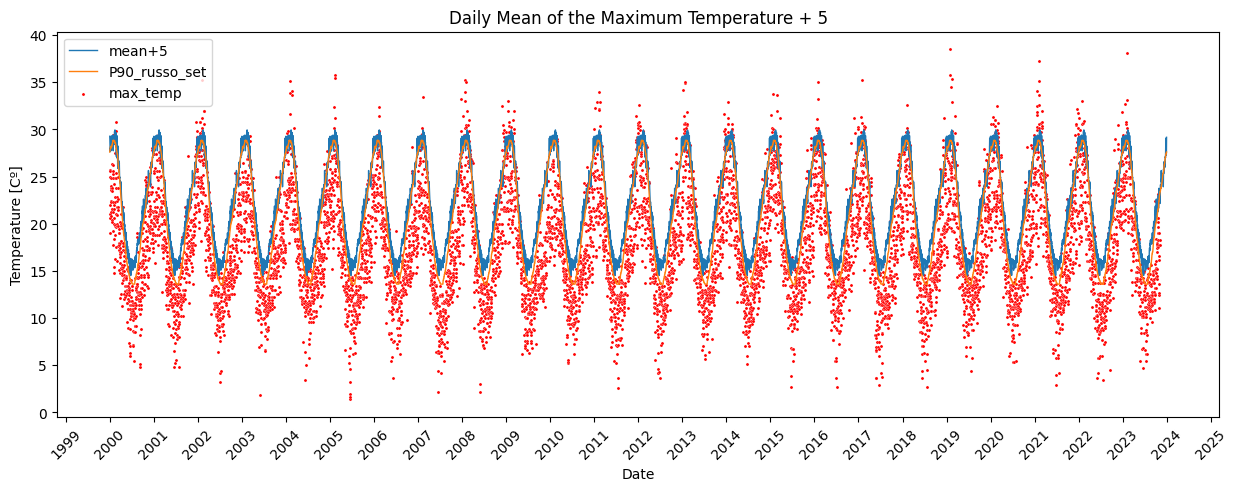

In [16]:
## Some plots for testig

fig, ax = plt.subplots(figsize=(15, 5))

Tadd = 5
Tcrit_type_1 = 'mean+'+str(Tadd)
Tcrit_1 = Tcrit(Tcrit_type_1, max_temp, Tadd)
sns.lineplot(Tcrit_1, y=Tcrit_type_1, x="date", label=Tcrit_type_1, lw=1)

Tcrit_type_2 = 'P90_russo_set'
sns.lineplot(Tcrit(Tcrit_type_2, max_temp, Tadd), y=Tcrit_type_2, x="date", label=Tcrit_type_2, lw=1)


Tind_type_1 = 'max_temp'
sns.scatterplot(Tind(Tind_type_1, max_temp), y=Tind_type_1, x="date", label=Tind_type_1, color = 'red', s=5)
#sns.scatterplot(max_temp_2023, y="max_temp", x="date", label="max_temp", color="red", s=2)

# plt.xlim([max_temp_2023.index.min(), datetime.now()])
# plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("Daily Mean of the Maximum Temperature + " + str(Tadd))

if end_date.year - start_date.year > 3:
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)




plt.show()

#max_temp_2023

In [465]:
#year

2020

In [18]:
Tind_type = 'Ta_min'
Tcrit_type = 'P85'
Nd = 2
data_temp = Ta_min #_data #min_temp

temp_Tind = Tind(Tind_type, data_temp) #min_temp)
temp_Tcrit = Tcrit(Tcrit_type, data_temp) #min_temp)
data_temp_2023 = pd.concat([temp_Tind, temp_Tcrit], axis = 1)


heatwaves_Ta_min = HWD(Tind_type, Tcrit_type, Nd, data_temp_2023)

fig, ax = plt.subplots(figsize=(15, 5))
plot_single_heatwave(heatwaves_Ta_min, data_temp_2023, Tind_type, Tcrit_type, Nd)

#print(type(heatwaves_russo))

NameError: name 'Ta_min' is not defined

In [19]:
Tind_type = 'Ta_max'
Tcrit_type = 'P85'
Nd = 2
data_temp = Ta_max #_data #min_temp

temp_Tind = Tind(Tind_type, data_temp) #min_temp)
temp_Tcrit = Tcrit(Tcrit_type, data_temp) #min_temp)
data_temp_2023 = pd.concat([temp_Tind, temp_Tcrit], axis = 1)


heatwaves_Ta_max = HWD(Tind_type, Tcrit_type, Nd, data_temp_2023)

fig, ax = plt.subplots(figsize=(15, 5))
plot_single_heatwave(heatwaves_Ta_max, data_temp_2023, Tind_type, Tcrit_type, Nd)

#print(type(heatwaves_russo))

NameError: name 'Ta_max' is not defined

In [27]:
temp_Tind_2 = Tind(Tind_type_1, max_temp)
temp_Tcrit_2 = Tcrit(Tcrit_type_2, max_temp, Tadd)
max_temp_2023 = pd.concat([temp_Tind_2, temp_Tcrit_2], axis = 1)


heatwaves_russo = HWD('max_temp', 'P90_russo_set', 3, max_temp_2023)

fig, ax = plt.subplots(figsize=(20, 5))
plot_single_heatwave(heatwaves_russo, max_temp_2023, 'max_temp', 'P90_russo_set', 3)

#print(type(heatwaves_russo))

KeyError: 'P90_russo_set'

a + a1*cos(omega*x) + b1*sin(omega*x) 

a :  20.9  CI ~ N [2.09e+01,2.09e+01]
a1 :  7.27  CI ~ N [7.23e+00,7.30e+00]
b1 :  1.77  CI ~ N [1.73e+00,1.80e+00]


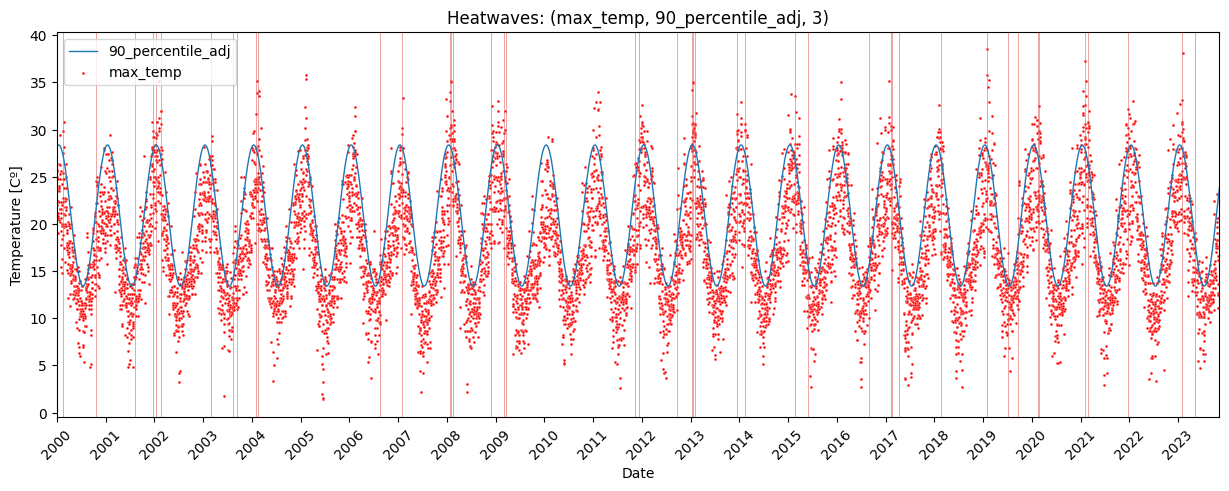

In [20]:
temp_Tind_3 = Tind('max_temp', max_temp)
temp_Tcrit_3 = Tcrit('90_percentile_adj', max_temp)
max_temp_2023_3 = pd.concat([temp_Tind_3, temp_Tcrit_3], axis = 1)


heatwaves_meteochile = HWD('max_temp', '90_percentile_adj', 3, max_temp_2023_3)

fig, ax = plt.subplots(figsize=(15, 5))
plot_single_heatwave(heatwaves_meteochile, max_temp_2023_3, 'max_temp', '90_percentile_adj', 3)

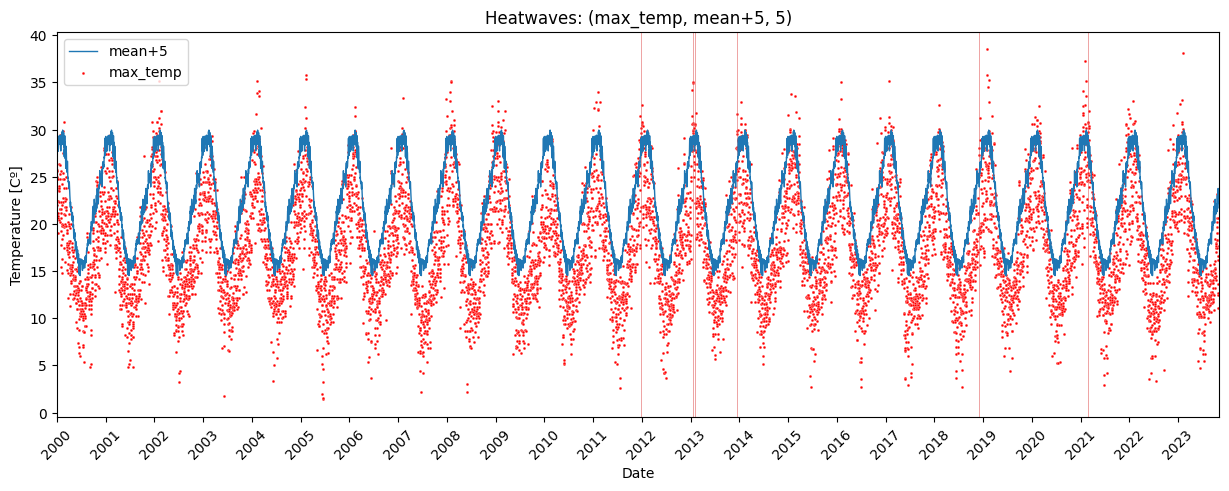

In [21]:
Tadd = 5
Nd = 5
Tcrit_type_2 = 'mean+' + str(Tadd)
temp_Tind_2 = Tind(Tind_type_1, max_temp)
temp_Tcrit_2 = Tcrit(Tcrit_type_2, max_temp, Tadd)
max_temp_2023 = pd.concat([temp_Tind_2, temp_Tcrit_2], axis = 1)


heatwaves_WMO = HWD('max_temp', 'mean+' + str(Tadd), Nd, max_temp_2023)
fig, ax = plt.subplots(figsize=(15, 5))
plot_single_heatwave(heatwaves_WMO, max_temp_2023, 'max_temp', 'mean+' + str(Tadd), Nd)

In [534]:
print(heatwaves_russo)
print(heatwaves_meteochile)
print(heatwaves_WMO)


        start        end  duration  mean_temp  min_temp  max_temp       date
0  2020-10-09 2020-10-12         4  29.700000      27.9      31.2 2020-10-11
1  2020-09-17 2020-09-23         7  27.342857      26.3      28.3 2020-09-19
2  2020-08-20 2020-08-22         3  24.866667      24.3      25.8 2020-08-21
3  2020-07-13 2020-07-15         3  23.233333      22.5      23.8 2020-07-14
4  2020-05-23 2020-05-25         3  27.366667      24.2      30.7 2020-05-25
5  2020-05-15 2020-05-17         3  27.500000      27.1      27.9 2020-05-17
6  2020-05-05 2020-05-09         5  27.260000      25.5      29.4 2020-05-07
7  2020-04-17 2020-04-22         6  29.366667      27.8      30.4 2020-04-20
8  2020-03-07 2020-03-11         5  32.560000      32.0      33.7 2020-03-09
9  2020-03-03 2020-03-05         3  33.000000      31.9      35.0 2020-03-05
10 2020-02-18 2020-02-20         3  34.233333      33.2      35.0 2020-02-18
11 2020-01-25 2020-01-27         3  34.266667      34.0      34.5 2020-01-26

In [535]:
print(type(heatwaves_WMO)) #['start']

<class 'pandas.core.frame.DataFrame'>


In [22]:
# Convert the 'start' and 'end' columns to datetime objects
#df1['start'] = pd.to_datetime(df1['start'])
#df1['end'] = pd.to_datetime(df1['end'])
#df2['start'] = pd.to_datetime(df2['start'])
#df2['end'] = pd.to_datetime(df2['end'])

def intersection_of_HWs(hw1: pd.DataFrame, hw2: pd.DataFrame):
    # Create an empty DataFrame to store the intersection
    intersection = pd.DataFrame(columns=hw1.columns)

    # Iterate through events in the first hw
    for index1, event1 in hw1.iterrows():
        start1, end1 = event1['start'], event1['end']

        # Iterate through events in the second hw
        for index2, event2 in hw2.iterrows():
            start2, end2 = event2['start'], event2['end']

            # Check for overlap
            if (start1 <= end2 and end1 >= start2):
                # If there is an overlap, then add the overlapping event
                #intersection = intersection.append(event1, ignore_index=True)
                intersection = pd.concat([intersection, event1.to_frame().T], ignore_index=True)
                #intersection = pd.append(intersection, event1, ignore_index=True)

    # keep only unique events
    intersection = intersection.drop_duplicates().reset_index(drop=True)

    # TODO: fix mean_temp, min_temp, max_temp, and see what 'date' is in the tabular.
    return intersection

def compoundHWD(hw1, hw2, Nd, logical_connect = 'and'): #Tind_type_1, Tcrit_1, Nd_1, Tind_type_2, Tcrit_type_2, Nd_2):
    intersection = intersection_of_HWs(hw1, hw2)
    ... # TODO: now the intersection needs to be evaluated with the number of days criteria, Nd.


int_russo_metochile = intersection_of_HWs(hw1=heatwaves_russo, hw2=heatwaves_meteochile)

int_russo_metochile


NameError: name 'heatwaves_russo' is not defined

In [23]:
def HWD1_and_HWD2(Tind_type_1: str, Tcrit_type_1:str, Tind_type_2:str, Tcrit_type_2:str, Nd:int, data_temp_2023_1: pd.DataFrame, data_temp_2023_2 = None):
    if data_temp_2023_2 is None:
        data_temp_2023 = data_temp_2023_1.copy()
    #elif data_temp_2023_1 == data_temp_2023_2:
    #    data_temp_2023 = data_temp_2023_1.copy()
    else:
        # common indices
        common_indices = data_temp_2023_1.index.intersection(data_temp_2023_2.index)
        data_temp_2023_1 = data_temp_2023_1.loc[common_indices]
        data_temp_2023_2 = data_temp_2023_2.loc[common_indices]

        # Create a new DataFrame with the common data
        #data_temp_2023 = pd.concat([common_data_1, common_data_2], axis=1)
        #print(data_temp_2023)

    # Align the columns
    #data_temp_2023[Tcrit_type_1], data_temp_2023[Tcrit_type_2] = data_temp_2023[Tcrit_type_1].align(data_temp_2023[Tcrit_type_2], axis=1, copy=False)

    # create binary column with 1 if the max_temp is above the (personal) threshold
    data_temp_2023_1.loc[:, "above_threshold"] = (
        (data_temp_2023_1[Tcrit_type_1] < data_temp_2023_1[Tind_type_1]) #& (data_temp_2023[Tcrit_type_2] < data_temp_2023[Tind_type_2])
        & (data_temp_2023_2[Tcrit_type_2] < data_temp_2023_2[Tind_type_2])
    ).astype(int)

    data_temp_2023_2.loc[:, "above_threshold"] = (
        (data_temp_2023_1[Tcrit_type_1] < data_temp_2023_1[Tind_type_1]) #& (data_temp_2023[Tcrit_type_2] < data_temp_2023[Tind_type_2])
        & (data_temp_2023_2[Tcrit_type_2] < data_temp_2023_2[Tind_type_2])
    ).astype(int)


    #data_temp_2023["above_threshold"] = (
    #    (data_temp_2023[Tcrit_type_1] < data_temp_2023[Tind_type_1]) & (data_temp_2023[Tcrit_type_2] < data_temp_2023[Tind_type_2])
    #).astype(int)

    #ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.
    print('aaaa')

    temps_above_threshold = data_temp_2023_1[data_temp_2023_1["above_threshold"] == 1].copy(deep=True)
    #temps_above_threshold_2 = data_temp_2023_1[data_temp_2023_1["above_threshold"] == 1].copy(deep=True)

    # create dataframe with heatwaves information (start, end, duration, mean_temp, max_temp, date)
    heatwaves = pd.DataFrame(
        columns=["start", "end", "duration", "mean_temp", "min_temp", "max_temp", "date"]
    )

    # get start and end of continuous heatwaves
    heatwaves_dates = []  # [(start, end), (start, end), ...]
    for i in range(1, len(temps_above_threshold)):
        # continuous heatwaves
        if temps_above_threshold.index[i] - temps_above_threshold.index[i - 1] == timedelta(days=1):
            # if empty, add first heatwave
            if len(heatwaves_dates) == 0:
                heatwaves_dates.append(
                    (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
                )
            # if not empty, check if the last heatwave is continuous
            else:
                # if continuous, update end date
                if heatwaves_dates[-1][1] == temps_above_threshold.index[i - 1]:
                    heatwaves_dates[-1] = (heatwaves_dates[-1][0], temps_above_threshold.index[i])
                # if not continuous, add new heatwave
                else:
                    heatwaves_dates.append(
                        (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
                    )

    data_temp_2023 = data_temp_2023_1.copy()
    #data_temp_2023_1 = data_temp_2023_1.copy()
    #heatwaves_1 = heatwaves.copy()
    #heatwaves_2 = heatwaves.copy()
    #heatwaves_dates_1 = heatwaves_dates.copy()
    #heatwaves_dates_2 = heatwaves_dates.copy()
    Tind_type = Tind_type_1
    for idx, hw_dates in enumerate(heatwaves_dates):
        # get start and end dates
        start = hw_dates[0]
        end = hw_dates[1]

        # get duration
        duration = (end - start).days + 1

        # get mean and max temp
        mean_temp = data_temp_2023.loc[start:end, Tind_type].mean() #"max_temp"].mean()
        min_temp = data_temp_2023.loc[start:end, Tind_type].min() #"max_temp"].min()
        max_temp = data_temp_2023.loc[start:end, Tind_type].max() #"max_temp"].max()
        Ta_max = data_temp_2023.loc[start:end, Tind_type].max() #"max_temp"].max()
        Ta_min = data_temp_2023.loc[start:end, Tind_type].max() #"max_temp"].max()

        # get max_temp date
        date = data_temp_2023.loc[start:end, Tind_type].idxmax() #"max_temp"].idxmax()

        # add to dataframe
        heatwaves.loc[idx] = [start, end, duration, mean_temp, min_temp, max_temp, date]

    # filter heatwaves with duration >= Nd days
    heatwaves = (
        heatwaves[heatwaves["duration"] >=  Nd]
        .sort_values(by="start", ascending=False)
        .reset_index(drop=True)
    )

    return heatwaves


#int_russo_metochile = intersection_of_HWs(hw1=heatwaves_russo, hw2=heatwaves_meteochile)
#int_russo_metochile



def plot_double_heatwave(heatwaves: pd.DataFrame,
                        data_temp_2023_1: pd.DataFrame,
                        data_temp_2023_2: pd.DataFrame,
                        Tind_type_1: str,
                        Tcrit_type_1: str,
                        Tind_type_2: str,
                        Tcrit_type_2: str,
                        Nd: int,
                        Temps_add = None
                        ):
    sns.lineplot(
        data_temp_2023_1,
        y=Tcrit_type_1,
        x="date",
        #label=r"$P_{90}^{over \ years} (T_{max}) $", #"Historic 90 percentile",
        label=Tcrit_type_1,
        color="black",
        lw=1,
    )

    sns.scatterplot(
        data_temp_2023_1,
        y=Tind_type_1,
        x="date",
        label=Tind_type_1,
        color="red",
        s=4,
    )

    sns.lineplot(
        data_temp_2023_2,
        y=Tcrit_type_2,
        x="date",
        #label=r"$P_{90}^{over \ years} (T_{max}) $", #"Historic 90 percentile",
        label=Tcrit_type_2,
        color = "black",
        lw=1,
    )

    sns.scatterplot(
        data_temp_2023_2,
        y=Tind_type_2,
        x="date",
        label=Tind_type_2,
        color="blue",
        s=4,
    )

    if Temps_add is not None:
        for i in range(len(Temps_add)):
            sns.lineplot(
                data_temp_2023_1,
                y=Temps_add[i],
                x="date",
                #label=r"$P_{90}^{over \ years} (T_{max}) $", #"Historic 90 percentile",
                label=Temps_add[i],
                color = "green",
                lw=1,
            )

    # vertical span for heatwaves
    heatwaves_dates = heatwaves[["start", "end"]].values
    for hw_dates in heatwaves_dates:
        plt.axvspan(hw_dates[0], hw_dates[1], facecolor="#DE4D4D", alpha=0.5)

    plt.xlim([data_temp_2023_1.index.min(), datetime.now()])
    #plt.xticks(rotation=45)

    if end_date.year - start_date.year > 3:
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.xticks(rotation=45)


    plt.xlabel("Date")
    plt.ylabel("Temperature [Cº]")
    plt.title("Heatwaves:" + ' (' + Tind_type_1 + ', ' + Tcrit_type_1 + ', ' + Tind_type_2 + ', ' + Tcrit_type_2 + ', ' + str(Nd) + ')')
    #+ r"$(T_{max}, \underset{over \ years}{Mean}(T_{max}),$" + str(Nd) + "$)$")
    plt.show()




In [24]:
## EPA (US) definition

Tind_type_1 = 'Ta_max'
Tcrit_type_1 = 'P85'
data_temp_1 = Ta_max
temp_Tind_1 = Tind(Tind_type_1, data_temp_1)
temp_Tcrit_1 = Tcrit(Tcrit_type_1, data_temp_1)
data_temp_2023_Ta_max_P85 = pd.concat([temp_Tind_1, temp_Tcrit_1], axis = 1)
#print(data_temp_2023_Ta_max)

Tind_type_2 = 'Ta_min'
Tcrit_type_2 = 'P85'
data_temp_2 = Ta_min
temp_Tind_2 = Tind(Tind_type_2, data_temp_2)
temp_Tcrit_2 = Tcrit(Tcrit_type_2, data_temp_2)
data_temp_2023_Ta_min_P85 = pd.concat([temp_Tind_2, temp_Tcrit_2], axis = 1)


Nd = 2

data_temp = data

heatwaves = HWD1_and_HWD2(Tind_type_1, Tcrit_type_1, Tind_type_2, Tcrit_type_2, Nd, data_temp_2023_Ta_max_P85, data_temp_2023_Ta_min_P85)

fig, ax = plt.subplots(figsize=(15, 5))
plot_double_heatwave(heatwaves, data_temp_2023_Ta_max_P85, data_temp_2023_Ta_min_P85, Tind_type_1, Tcrit_type_1,
                        Tind_type_2, Tcrit_type_2, Nd)

NameError: name 'Ta_max' is not defined

In [25]:
### EuroHeat Definition

Tind_type_1 = 'Ta_max'
Tcrit_type_1 = 'P90'
data_temp_1 = Ta_max
temp_Tind_1 = Tind(Tind_type_1, data_temp_1)
temp_Tcrit_1 = Tcrit(Tcrit_type_1, data_temp_1)
data_temp_2023_Ta_max_P90 = pd.concat([temp_Tind_1, temp_Tcrit_1], axis = 1)
#print(data_temp_2023_1)

Tind_type_2 = 'min_temp'
Tcrit_type_2 = 'P90'
data_temp_2 = min_temp
temp_Tind_2 = Tind(Tind_type_2, data_temp_2)
temp_Tcrit_2 = Tcrit(Tcrit_type_2, data_temp_2)
data_temp_2023_min_temp_P90 = pd.concat([temp_Tind_2, temp_Tcrit_2], axis = 1)


Nd = 2

data_temp = data

#Temps_add = [data_temp_2023_max_temp_90, 'Ta_min']
#Temps_add = ['max_temp', 'Ta_min']

heatwaves = HWD1_and_HWD2(Tind_type_1, Tcrit_type_1, Tind_type_2, Tcrit_type_2, Nd, data_temp_2023_Ta_max_P90, data_temp_2023_min_temp_P90)

fig, ax = plt.subplots(figsize=(15, 5))
plot_double_heatwave(heatwaves, data_temp_2023_Ta_max_P90, data_temp_2023_min_temp_P90, Tind_type_1, Tcrit_type_1,
                        Tind_type_2, Tcrit_type_2, Nd) #, Temps_add, Temps_add_types)

NameError: name 'Ta_max' is not defined

aaaa


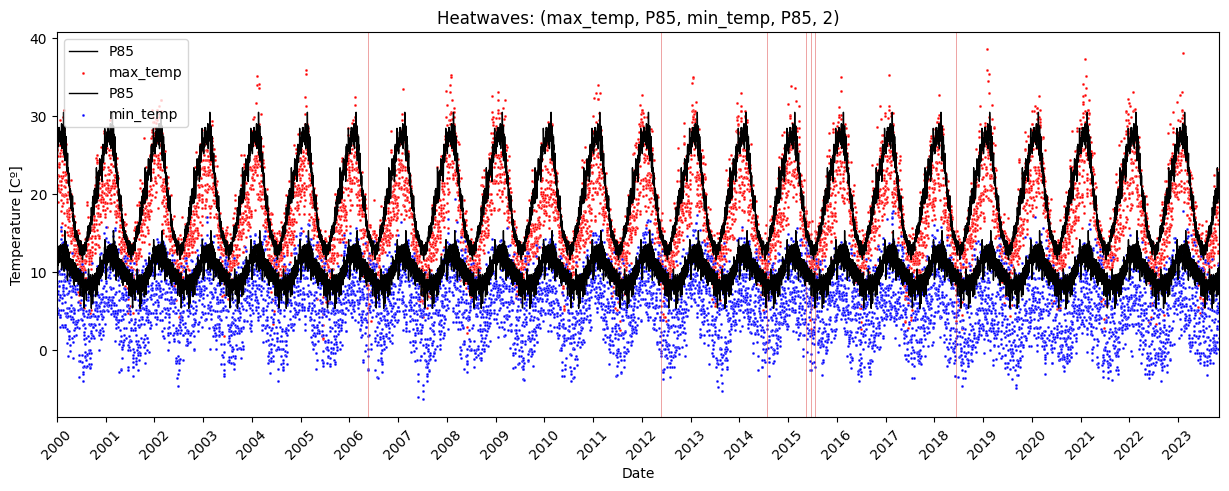

In [26]:
### Alternative to US and EU Definition

Tind_type_1 = 'max_temp'
Tcrit_type_1 = 'P85'
data_temp_1 = max_temp
temp_Tind_1 = Tind(Tind_type_1, data_temp_1)
temp_Tcrit_1 = Tcrit(Tcrit_type_1, data_temp_1)
data_temp_2023_1 = pd.concat([temp_Tind_1, temp_Tcrit_1], axis = 1)
#print(data_temp_2023_1)

Tind_type_2 = 'min_temp'
Tcrit_type_2 = 'P85'
data_temp_2 = min_temp
temp_Tind_2 = Tind(Tind_type_2, data_temp_2)
temp_Tcrit_2 = Tcrit(Tcrit_type_2, data_temp_2)
data_temp_2023_2 = pd.concat([temp_Tind_2, temp_Tcrit_2], axis = 1)


Nd = 2

data_temp = data

heatwaves = HWD1_and_HWD2(Tind_type_1, Tcrit_type_1, Tind_type_2, Tcrit_type_2, Nd, data_temp_2023_1, data_temp_2023_2)

fig, ax = plt.subplots(figsize=(15, 5))
plot_double_heatwave(heatwaves, data_temp_2023_1, data_temp_2023_2, Tind_type_1, Tcrit_type_1,
                        Tind_type_2, Tcrit_type_2, Nd)

In [603]:
# add the 90-percentile from MeteoChile to the dataframe
#max_temp_2023 = max_temp_2023.join(df_melted)

# create binary column with 1 if the max_temp is above the (personal) threshold
max_temp_2023.loc[:, "above_threshold"] = (
    max_temp_2023["mean+" + str(Tadd)] < max_temp_2023["max_temp"]
).astype(int)

temps_above_threshold = max_temp_2023[max_temp_2023["above_threshold"] == 1].copy(deep=True)

# create dataframe with heatwaves information (start, end, duration, mean_temp, max_temp, date)
heatwaves = pd.DataFrame(
    columns=["start", "end", "duration", "mean_temp", "min_temp", "max_temp", "date"]
)

# get start and end of continuous heatwaves
heatwaves_dates = []  # [(start, end), (start, end), ...]
for i in range(1, len(temps_above_threshold)):
    # continuous heatwaves
    if temps_above_threshold.index[i] - temps_above_threshold.index[i - 1] == dt.timedelta(days=1):
        # if empty, add first heatwave
        if len(heatwaves_dates) == 0:
            heatwaves_dates.append(
                (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
            )
        # if not empty, check if the last heatwave is continuous
        else:
            # if continuous, update end date
            if heatwaves_dates[-1][1] == temps_above_threshold.index[i - 1]:
                heatwaves_dates[-1] = (heatwaves_dates[-1][0], temps_above_threshold.index[i])
            # if not continuous, add new heatwave
            else:
                heatwaves_dates.append(
                    (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
                )

for idx, hw_dates in enumerate(heatwaves_dates):
    # get start and end dates
    start = hw_dates[0]
    end = hw_dates[1]

    # get duration
    duration = (end - start).days + 1

    # get mean and max temp
    mean_temp = max_temp_2023.loc[start:end, "max_temp"].mean()
    min_temp = max_temp_2023.loc[start:end, "max_temp"].min()
    max_temp = max_temp_2023.loc[start:end, "max_temp"].max()

    # get max_temp date
    date = max_temp_2023.loc[start:end, "max_temp"].idxmax()

    # add to dataframe
    heatwaves.loc[idx] = [start, end, duration, mean_temp, min_temp, max_temp, date]

# filter heatwaves with duration >= 3 days
heatwaves = (
    heatwaves[heatwaves["duration"] >=  Nd]
    .sort_values(by="start", ascending=False)
    .reset_index(drop=True)
)

heatwaves

NameError: name 'dt' is not defined

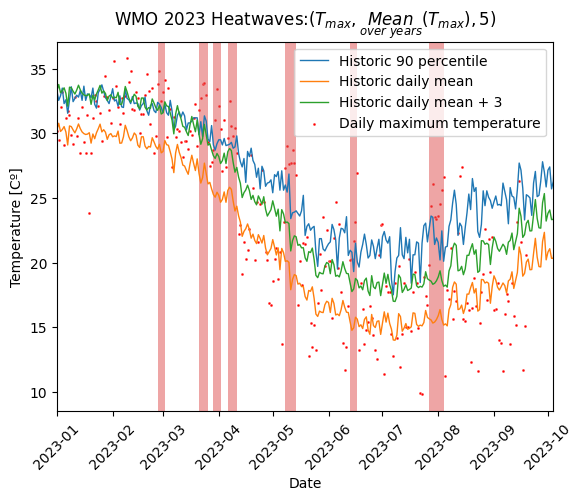

In [144]:
sns.lineplot(
    max_temp_2023,
    y="P90",
    x="date",
    #label=r"$P_{90}^{over \ years} (T_{max}) $", #"Historic 90 percentile",
    label="Historic 90 percentile",
    lw=1,
)


sns.lineplot(
    max_temp_2023,
    y="mean",
    x="date",
    label="Historic daily mean",
    lw=1,
)

sns.lineplot(
    max_temp_2023,
    y="mean+" + str(Tadd),
    x="date",
    label="Historic daily mean + " + str(Tadd),
    lw=1,
)

sns.scatterplot(
    max_temp_2023,
    y="max_temp",
    x="date",
    label="Daily maximum temperature",
    color="red",
    s=4,
)

# vertical span for heatwaves
heatwaves_dates = heatwaves[["start", "end"]].values
for hw_dates in heatwaves_dates:
    plt.axvspan(hw_dates[0], hw_dates[1], facecolor="#DE4D4D", alpha=0.5)

plt.xlim([max_temp_2023.index.min(), datetime.now()])
plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("WMO 2023 Heatwaves:" + r"$(T_{max}, \underset{over \ years}{Mean}(T_{max}),$" + str(Nd) + "$)$")
plt.show()

## Def: Russo 2014

## MeteoChile - Extreme threshold


### New Methodology

The **daily 90-percentile computation** is done through **HANTS**. Main idea is the following:

1. adjust a function that represents the series
2. compute `max_temp` columns according to the adjusted function
3. get the **90-percentile** from the simulated values given by the predicted values


In [7]:
from calendar import monthrange
from datetime import datetime

# get the number of days in each month for given year
#   - with this data we can compute the ext_threhold for each month/day in the year
year = datetime.now().year
month_days = {"year": year, "month_days": {m: monthrange(year, m)[1] for m in range(1, 13)}}
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

month_days

{'year': 2023,
 'month_days': {1: 31,
  2: 28,
  3: 31,
  4: 30,
  5: 31,
  6: 30,
  7: 31,
  8: 31,
  9: 30,
  10: 31,
  11: 30,
  12: 31}}

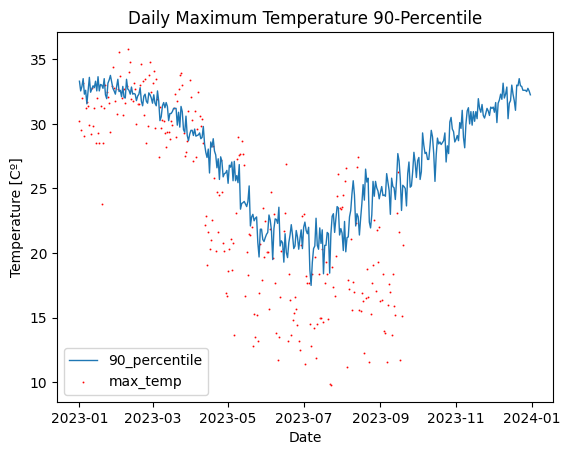

,max_temp,90_percentile
date,,
2023-01-01,30.2,33.3
2023-01-02,29.5,32.55
2023-01-03,32.0,32.9
2023-01-04,33.2,33.5
2023-01-05,29.1,32.3
...,...,...
2023-12-27,NaN,32.6
2023-12-28,NaN,32.5
2023-12-29,NaN,32.75


In [10]:
# compute the 90-percentile for each month/day in the year
max_temp_2023 = pd.DataFrame(
    [],
    columns=["max_temp", "90_percentile"],
    index=pd.Index(pd.date_range(start_date, end_date, freq="D"), name="date"),
)

# add entries from 2023
max_temp_2023["max_temp"] = max_temp[max_temp.index.year == 2023]

for month in month_days["month_days"]:
    for day in range(1, month_days["month_days"][month] + 1):
        # the period used to compute the extreme threhold is 1981-2010 (Meteochile, 2020)
        # TODO: validate with scatter plot: 90-percentile vs max_temp (w/ different colors)
        f_max_temp = max_temp[
            (1981 <= max_temp.index.year)
            & (max_temp.index.year <= 2010)
            & (max_temp.index.day == day)
            & (max_temp.index.month == month)
        ]

        # TODO: update the following line with the 90_percentile from the HANTS adjusted data
        # * Discuss interpolation param with @elwin. It's clear it is not 'lower'|' higher'|'nearest'
        # * as the value is not in the data. But, what is the best option? 'midpoint' | 'linear'?
        max_temp_2023.loc[datetime(year, month, day), "90_percentile"] = f_max_temp.quantile(
            0.9, interpolation="midpoint"
        ).values[0]

sns.lineplot(max_temp_2023, y="90_percentile", x="date", label="90_percentile", lw=1)
sns.scatterplot(max_temp_2023, y="max_temp", x="date", label="max_temp", color="red", s=2)

# plt.xlim([max_temp_2023.index.min(), datetime.now()])
# plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("Daily Maximum Temperature 90-Percentile")
plt.show()

max_temp_2023

1. fit sin() in the above table.
2. feq = 0, this time we only consider constant Trend (a + bt -> a)


a + a1*cos(omega*x) ¿+ b1*sin(omega*x) 

a :  27.5  CI ~ N [2.74e+01,2.76e+01]
a1 :  5.81  CI ~ N [5.64e+00,5.98e+00]
b1 :  0.991  CI ~ N [8.24e-01,1.16e+00]

RSS model sine curve : 324.34


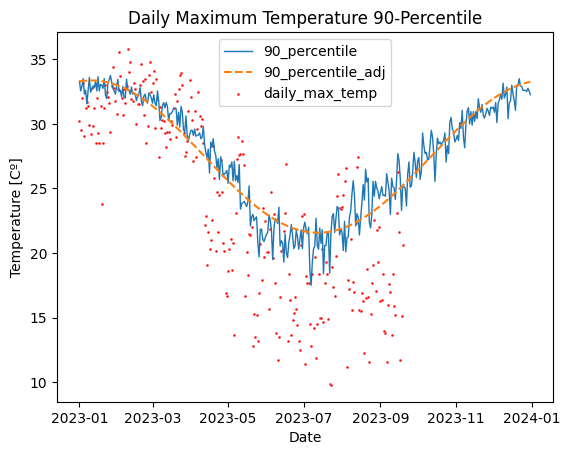

,max_temp,90_percentile,90_percentile_adj
date,,,
2023-01-01,30.2,33.3,33.278560
2023-01-02,29.5,32.55,33.294753
2023-01-03,32.0,32.9,33.309223
2023-01-04,33.2,33.5,33.321965
2023-01-05,29.1,32.3,33.332975
...,...,...,...
2023-12-27,NaN,32.6,33.165478
2023-12-28,NaN,32.5,33.190630
2023-12-29,NaN,32.75,33.214089


In [11]:
# TODO: improve fitting of function
# compute the 90-percentile for the given day
import datetime as dt
from scipy.stats import norm
from scipy.optimize import curve_fit


# new method
temp_t = max_temp_2023["90_percentile"].copy(deep=True)
temp_t = temp_t.to_frame()


def model(x, params):
    a, a1, b1 = params
    omega = 2 * np.pi / 365.25  # 365.25
    theta = np.arctan(a1 / b1)
    alpha = np.sqrt(a1**2 + b1**2)

    y_pred = a + alpha * np.sin(omega * x + theta)
    return y_pred


def model_fit(x, a, a1, b1):
    omega = 2 * np.pi / 365.25
    y_pred = a + a1 * np.cos(omega * x) + b1 * np.sin(omega * x)
    return y_pred


def RSS(y, y_pred) -> float:
    return np.sqrt((y - y_pred) ** 2).sum()


if isinstance(temp_t.index, pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index = temp_t.index.map(dt.datetime.toordinal)


params, cov = curve_fit(
    model_fit, xdata=temp_t.index - first_ord, ydata=temp_t["90_percentile"], method="lm"
)
param_list = ["a", "a1", "b1"]
print("a + a1*cos(omega*x) + b1*sin(omega*x) \n")

std_dev = np.sqrt(np.diag(cov))
for name, p, sd in zip(param_list, params, std_dev):
    print(
        "{0} :  {1:0.3}  CI ~ N [{2:0.2e},{3:0.2e}]".format(name, p, p - 1.96 * sd, p + 1.96 * sd)
    )

max_temp_2023.loc[:, "90_percentile_adj"] = model(temp_t.index - first_ord, params)
if isinstance(temp_t.index, pd.DatetimeIndex):
    temp_t.index = temp_t.index.map(dt.datetime.toordinal)

print(
    "\nRSS model sine curve :",
    round(
        RSS(
            max_temp_2023["90_percentile"].astype(float),
            max_temp_2023["90_percentile_adj"].astype(float),
        ),
        2,
    ),
)

sns.lineplot(max_temp_2023, y="90_percentile", x="date", label="90_percentile", lw=1)
sns.lineplot(
    max_temp_2023, y="90_percentile_adj", x="date", label="90_percentile_adj", lw=1.5, ls="--"
)
sns.scatterplot(max_temp_2023, y="max_temp", x="date", label="daily_max_temp", color="red", s=4)

# plt.xlim([max_temp_2023.index.min(), datetime.now()])
# plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("Daily Maximum Temperature 90-Percentile")
plt.show()

max_temp_2023

In [10]:
# get threholds from Meteochile for the station of interest
thresholds_meteochile = su.html_table_to_xlsx(
    f"https://climatologia.meteochile.gob.cl/application/historico/umbralesOlasDeCalorEstacion/{STATION_ID}",
    "excel",  # this can be checked out on the source code of the page
    f"{INPUT_PATH}/thresholds.xlsx",
)
thresholds_meteochile

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
day,,,,,,,,,,,,
1,32.5,33.0,32.1,29.4,25.7,22.3,20.9,21.9,24.4,27.2,29.5,31.2
2,32.5,33.0,32.0,29.3,25.5,22.2,20.9,21.9,24.5,27.2,29.6,31.3
3,32.6,33.0,32.0,29.1,25.4,22.1,20.9,22.0,24.6,27.3,29.6,31.3
4,32.6,32.9,31.9,29.0,25.3,22.1,20.9,22.1,24.7,27.4,29.7,31.4
5,32.6,32.9,31.8,28.9,25.2,22.0,20.9,22.1,24.8,27.5,29.8,31.4
6,32.7,32.9,31.8,28.8,25.0,21.9,20.9,22.2,24.9,27.6,29.8,31.5
7,32.7,32.9,31.7,28.7,24.9,21.8,20.9,22.3,25.0,27.7,29.9,31.5
8,32.7,32.9,31.6,28.6,24.8,21.8,20.9,22.3,25.1,27.7,30.0,31.6
9,32.7,32.9,31.5,28.4,24.7,21.7,20.9,22.4,25.1,27.8,30.0,31.6


In [11]:
# First, reset the index to move day into a column
df = thresholds_meteochile.reset_index()

# Then use `melt` to reverse the pivot
df_melted = df.melt(id_vars="day", var_name="month", value_name="90_percentile_meteochile")

# Convert month name back to number
months_mapper = {f"{i:02d}": dt.date(1900, i, 1).strftime("%b") for i in range(1, 13)}
r_months_mapper = {v: k for k, v in months_mapper.items()}  # reverse the mapper
df_melted["month"] = df_melted["month"].map(r_months_mapper)

# Convert day and month to integer for proper sorting
df_melted["month"] = df_melted["month"].astype(int)
df_melted["day"] = df_melted["day"].astype(int)

# Sort by month and day
df_melted.sort_values(by=["month", "day"], inplace=True)

# If you want to reset the index
df_melted = df_melted.dropna().reset_index(drop=True)

# remove 2023-02-29
df_melted = df_melted[~((df_melted.month == 2) & (df_melted.day == 29))]

# datetime index for current year from day and month columns
df_melted["date"] = df_melted[["month", "day"]].apply(
    lambda x: dt.date(2023, x.month, x.day), axis=1
)
df_melted.drop(columns=["month", "day"], inplace=True)
df_melted.set_index("date", inplace=True, drop=True)

df_melted

,90_percentile_meteochile
date,
2023-01-01,32.5
2023-01-02,32.5
2023-01-03,32.6
2023-01-04,32.6
2023-01-05,32.6
...,...
2023-12-27,32.4
2023-12-28,32.4
2023-12-29,32.4


In [12]:
# reproduce MeteoChile 'Umbrales Olas de Calor (Diurna)' report to check whether the HANTS
# algorithm is working as expected regarding the defintion of the 90-percentile
ans = max_temp_2023[["90_percentile_adj"]].copy(deep=True)

ans["month"] = ans.index.strftime("%m")
ans["day"] = ans.index.strftime("%d")

thresholds_pivot = ans.pivot(index="day", columns="month", values="90_percentile_adj").rename(
    columns=months_mapper
)
thresholds_pivot.index = thresholds_pivot.index.astype(int)
thresholds_pivot = thresholds_pivot.round(1)

thresholds_pivot

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
day,,,,,,,,,,,,
1,33.3,33.0,31.4,28.6,25.6,23.0,21.7,21.9,23.7,26.4,29.5,32.0
2,33.3,32.9,31.3,28.5,25.5,22.9,21.7,21.9,23.7,26.5,29.6,32.0
3,33.3,32.9,31.2,28.4,25.4,22.9,21.7,22.0,23.8,26.6,29.7,32.1
4,33.3,32.9,31.1,28.3,25.3,22.8,21.6,22.0,23.9,26.7,29.8,32.1
5,33.3,32.8,31.1,28.2,25.2,22.8,21.6,22.1,24.0,26.8,29.9,32.2
6,33.3,32.8,31.0,28.1,25.1,22.7,21.6,22.1,24.1,26.9,29.9,32.3
7,33.3,32.7,30.9,28.0,25.0,22.6,21.6,22.1,24.2,27.0,30.0,32.3
8,33.4,32.7,30.8,27.9,24.9,22.6,21.6,22.2,24.2,27.1,30.1,32.4
9,33.4,32.6,30.7,27.8,24.8,22.5,21.6,22.2,24.3,27.2,30.2,32.4


In [13]:
# add the 90-percentile from MeteoChile to the dataframe
max_temp_2023 = max_temp_2023.join(df_melted)

# create binary column with 1 if the max_temp is above the (personal) threshold
max_temp_2023.loc[:, "above_threshold"] = (
    max_temp_2023["90_percentile_adj"] < max_temp_2023["max_temp"]
).astype(int)

temps_above_threshold = max_temp_2023[max_temp_2023["above_threshold"] == 1].copy(deep=True)

# create dataframe with heatwaves information (start, end, duration, mean_temp, max_temp, date)
heatwaves = pd.DataFrame(
    columns=["start", "end", "duration", "mean_temp", "min_temp", "max_temp", "date"]
)

# get start and end of continuous heatwaves
heatwaves_dates = []  # [(start, end), (start, end), ...]
for i in range(1, len(temps_above_threshold)):
    # continuous heatwaves
    if temps_above_threshold.index[i] - temps_above_threshold.index[i - 1] == dt.timedelta(days=1):
        # if empty, add first heatwave
        if len(heatwaves_dates) == 0:
            heatwaves_dates.append(
                (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
            )
        # if not empty, check if the last heatwave is continuous
        else:
            # if continuous, update end date
            if heatwaves_dates[-1][1] == temps_above_threshold.index[i - 1]:
                heatwaves_dates[-1] = (heatwaves_dates[-1][0], temps_above_threshold.index[i])
            # if not continuous, add new heatwave
            else:
                heatwaves_dates.append(
                    (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
                )

for idx, hw_dates in enumerate(heatwaves_dates):
    # get start and end dates
    start = hw_dates[0]
    end = hw_dates[1]

    # get duration
    duration = (end - start).days + 1

    # get mean and max temp
    mean_temp = max_temp_2023.loc[start:end, "max_temp"].mean()
    min_temp = max_temp_2023.loc[start:end, "max_temp"].min()
    max_temp = max_temp_2023.loc[start:end, "max_temp"].max()

    # get max_temp date
    date = max_temp_2023.loc[start:end, "max_temp"].idxmax()

    # add to dataframe
    heatwaves.loc[idx] = [start, end, duration, mean_temp, min_temp, max_temp, date]

# filter heatwaves with duration >= 3 days
heatwaves = (
    heatwaves[heatwaves["duration"] >= 3]
    .sort_values(by="start", ascending=False)
    .reset_index(drop=True)
)

heatwaves

,start,end,duration,mean_temp,min_temp,max_temp,date
0,2023-05-08,2023-05-14,7,27.828571,26.8,29.0,2023-05-09
1,2023-04-06,2023-04-11,6,30.233333,28.5,32.5,2023-04-07
2,2023-03-30,2023-04-02,4,31.700000,30.3,33.4,2023-03-31
3,2023-03-21,2023-03-26,6,32.416667,29.3,33.9,2023-03-24
4,2023-02-26,2023-03-02,5,33.680000,32.5,34.8,2023-02-27
5,2023-02-19,2023-02-21,3,33.633333,33.0,34.6,2023-02-20
6,2023-02-08,2023-02-11,4,34.375000,32.9,35.8,2023-02-09


In [14]:
# TODO: automate over years
yearly_hw_stats = pd.DataFrame(
    [],
    index=pd.Index([], name="year", dtype=int),
    columns=[
        "n_hw",
        "mean_hw_temp",
        "max_hw_temp",
        "min_hw_temp",
        "mean_hw_duration",
        "max_hw_duration",
        "min_hw_duration",
    ],
)

yearly_hw_stats.loc[2023, "n_hw"] = len(heatwaves)
yearly_hw_stats.loc[2023, "mean_hw_temp"] = heatwaves["mean_temp"].mean()
yearly_hw_stats.loc[2023, "max_hw_temp"] = heatwaves["max_temp"].max()
yearly_hw_stats.loc[2023, "min_hw_temp"] = heatwaves["min_temp"].min()
yearly_hw_stats.loc[2023, "mean_hw_duration"] = heatwaves["duration"].mean()
yearly_hw_stats.loc[2023, "max_hw_duration"] = heatwaves["duration"].max()
yearly_hw_stats.loc[2023, "min_hw_duration"] = heatwaves["duration"].min()

yearly_hw_stats

,n_hw,mean_hw_temp,max_hw_temp,min_hw_temp,mean_hw_duration,max_hw_duration,min_hw_duration
year,,,,,,,
2023,7,31.980986,35.8,26.8,5.0,7,3


In [15]:
# TODO: per station historic stats

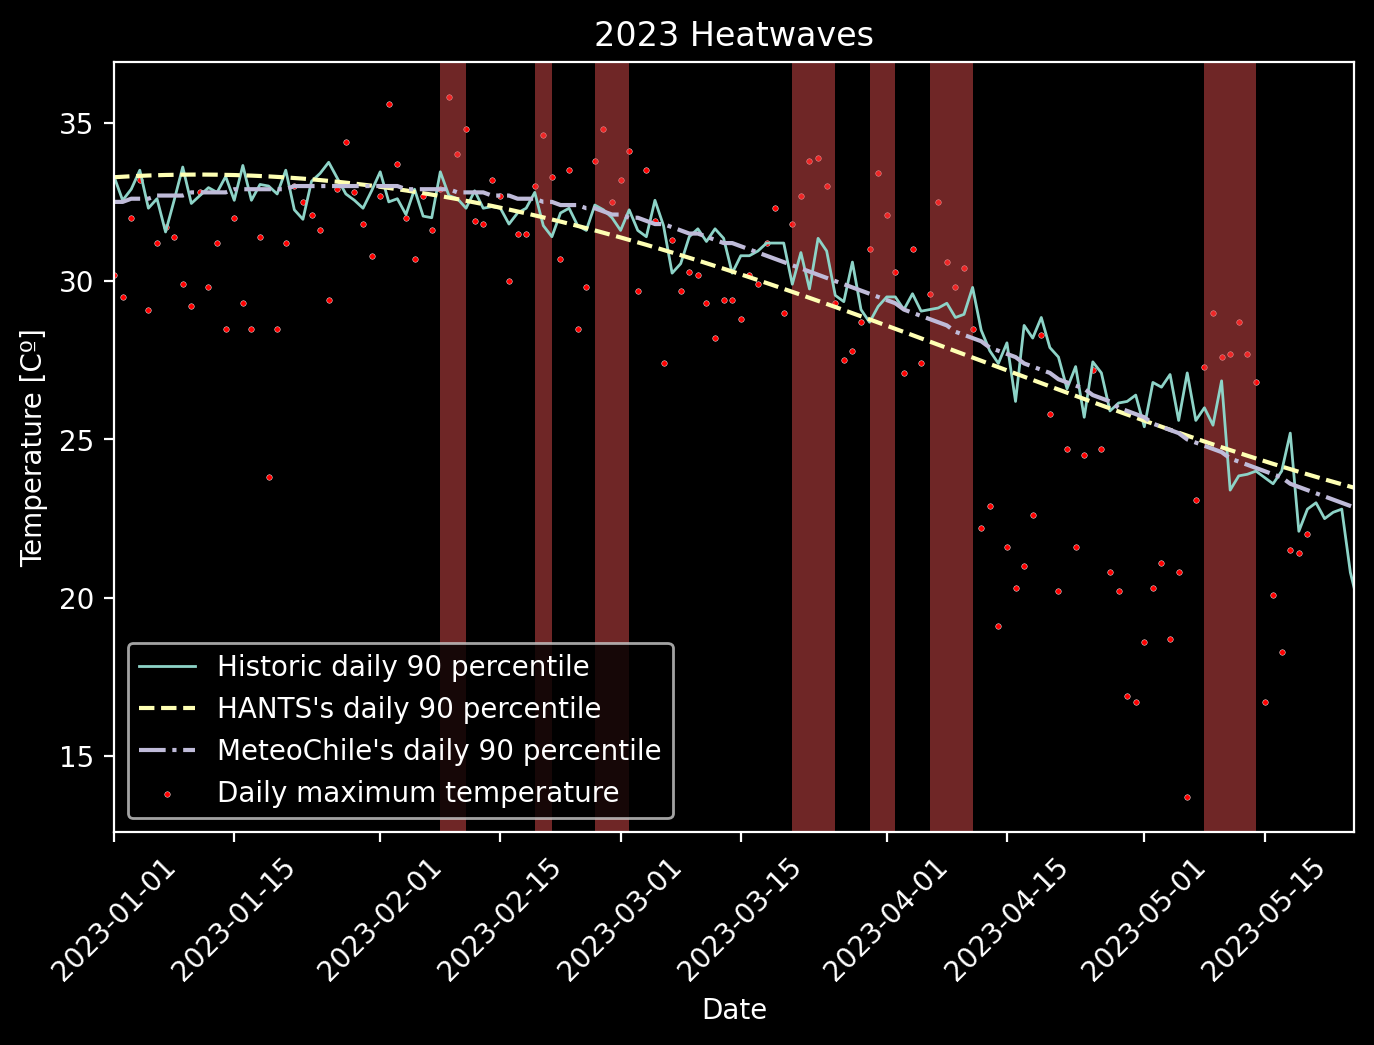

In [16]:
sns.lineplot(
    max_temp_2023,
    y="90_percentile",
    x="date",
    label="Historic daily 90 percentile",
    lw=1,
)
sns.lineplot(
    max_temp_2023,
    y="90_percentile_adj",
    x="date",
    label="HANTS's daily 90 percentile",
    lw=1.5,
    ls="--",
)
sns.lineplot(
    max_temp_2023,
    y="90_percentile_meteochile",
    x="date",
    label="MeteoChile's daily 90 percentile",
    lw=1.5,
    ls="-.",
)
sns.scatterplot(
    max_temp_2023,
    y="max_temp",
    x="date",
    label="Daily maximum temperature",
    color="red",
    s=4,
)

# vertical span for heatwaves
heatwaves_dates = heatwaves[["start", "end"]].values
for hw_dates in heatwaves_dates:
    plt.axvspan(hw_dates[0], hw_dates[1], facecolor="#DE4D4D", alpha=0.5)

plt.xlim([max_temp_2023.index.min(), datetime.now()])
plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("2023 Heatwaves")
plt.show()